## Reduced Rank Regression

In [ ]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Load the data
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')

In [3]:
filtered_data = filter_data(data)

In [4]:
# Create a NaN mask
nan_mask = create_nan_mask(filtered_data)

# Apply the NaN mask
masked_data = remove_nans_1(filtered_data, nan_mask)

100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [5]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


In [6]:
reshaped_data = reshape_data(masked_data)

100%|██████████| 34/34 [01:13<00:00,  2.16s/it]


In [7]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [8]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [9]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

In [10]:
# Only keep the first 3 models for training / testing pipeline

# Select the first 3 models
selected_models = list(data_forced_responses.keys())[:10]
selected_data = {model: data_forced_responses[model] for model in selected_models}

In [11]:
data_without_nans = remove_nans(selected_data, nan_mask)

### The data is now in the shape : Time x # of grid cells 

In [12]:
# Keep only the first 2 models as an example
example_models = list(data_without_nans.keys())[:10]
example_models

['ICON-ESM-LR',
 'EC-Earth3',
 'CMCC-CM2-SR5',
 'ACCESS-CM2',
 'CESM2',
 'CNRM-ESM2-1',
 'IPSL-CM6A-LR',
 'GISS-E2-2-G',
 'CNRM-CM6-1',
 'CanESM5-1']

In [13]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(example_models)
train_models = [model for model in example_models if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['ICON-ESM-LR', 'EC-Earth3', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1']
Testing model: CMCC-CM2-SR5


In [14]:
test_data.keys()

dict_keys(['CMCC-CM2-SR5'])

In [15]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)

100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


## Now that the data has been normalized (and NaN values removed), it's time to do the Reduced Rank Regression (RRR)

In [16]:
# First pool the data together
X_full, Y_full = pool_data(normalized_train_data)

In [17]:
X_full.shape, Y_full.shape # Shape is correct

((35475, 6523), (35475, 6523))

In [70]:
rank = 3000 # Used as a starting point
lambda_ = 0.01 # This will be optimized later
Brr = reduced_rank_regression(X_full, Y_full, rank, lambda_)

In [71]:
print(Brr.shape)

(6523, 6523)


In [72]:
# Test a prediction on the test set for a single run

# Select a random run from the test set
test_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
test_run = normalized_test_data[test_model][random.choice(test_runs)]
ground_truth = normalized_test_data[test_model]['forced_response']

In [73]:
test_run.shape, ground_truth.shape

((165, 6523), (165, 6523))

In [74]:
# make the prediction

prediction = test_run @ Brr
prediction.shape

(165, 6523)

In [75]:
# Add the NaN values back to the correct spots
predictions = True
prediction = readd_nans(prediction, nan_mask, predictions)
test_run = readd_nans(test_run, nan_mask, predictions)
ground_truth = readd_nans(ground_truth, nan_mask, predictions)

In [76]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

Displaying the forced response and runs for grid spot: [35 84]


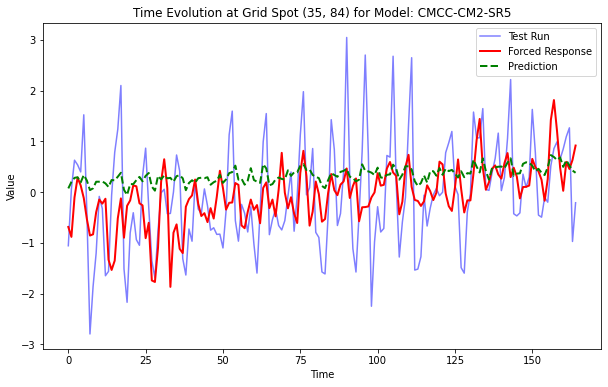

In [90]:
# Select a random grid spot
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run (minus the forced response)
input_data = test_run.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the forced response
forced_response_data = ground_truth.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the prediction
predicted_data = prediction.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs, the forced response, and the prediction
plt.figure(figsize=(10, 6))
plt.plot(input_data, color='blue', alpha=0.5, label='Test Run')
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.plot(predicted_data, color='green', label='Prediction', linewidth=2, linestyle='--')
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {test_model}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [65]:
print(f"The shape of the data is: {X_full.shape}")
print(f"The shape of the target is: {Y_full.shape}")
print(f"The maximum, minimum, average and std for the input data are: {np.max(X_full)}, {np.min(X_full)}, {np.mean(X_full)}, {np.std(X_full)}")
print(f"The maximum, minimum, average and std for the target data are: {np.max(Y_full)}, {np.min(Y_full)}, {np.mean(Y_full)}, {np.std(Y_full)}")

The shape of the data is: (35475, 6523)
The shape of the target is: (35475, 6523)
The maximum, minimum, average and std for the input data are: 42.12560053008167, -7610.598601598949, -0.38787908561791024, 22.45946965896203
The maximum, minimum, average and std for the target data are: 40.78550689969676, -7608.745755742709, -0.38787908561790924, 22.437196290130114
